# VMM Bias-variance tradeoff

The accelerations ($y$) obtained from the model tests are generated by the unknown real model $f(x)$ and the irreducible error $\epsilon \sim \mathcal{N}(0,\sigma^2)$ .

$$
y = f(x) + \epsilon
$$ (eq_y)

In the VMM:s $\hat{f}(x)$ (predictor) approximates the true model $f(x)$ 

$$
y = \hat{f}(x) + \epsilon_G
$$ (eq_y)

The predictor is fitted on a dataset $D$ (the model tests).

$$
D = \{(x_1,y_1)..(x_n,y_n) \}
$$ (eq_D)

$$
y = \hat{f}_D(x) + \epsilon_G
$$ (eq_y)

For the predictor to be usefull it must perform well on unseen data so that it generalizes to $x$ values outside the training dataset $D$. The predictor will then have a generalization error which can be decomposed in bias error, variance and irreducible error. The bias error describes how well the predictor $\hat{f}(x)$ approximates the real model ${f}(x)$. The variance describes the robustness of the predictor, how much it changes with different training datasets. The irreducible error origins from inherent noise in the problem itself and is an error term that will always be present.

A simple predictor simplifies the real model too much giving a high bias error. A simple model is not so sensitive to the training data and are therefore robust and has a similar performance regardless of the training dataset which giving a low variance. 
A more complex model acts more like the real model giving lower bias but may also have a high variance if the model generalizes very badly to data outside the training dataset.
Very simple models underfitts the training data and the too complex models overfitts it.  
The goal is to create a predictor with both low bias error and low variance which usually is a tradeoff between the two.

The expected error of $\hat{f}(x)$ on unseen sample $x$ can be decomposed as:

$$
\mathop{\mathbb{E_D}} \left[ (y-\hat{f}_D(x))^2 \right] = MSE = \left( Bias_D[\hat{f}(x)]\right)^2 +Var_D[\hat{f}(x)] + \sigma^2
$$ (eq_bias_variance)

$$
Bias_D[\hat{f}(x)] = \mathop{\mathbb{E_D}} \left[\hat{f}_D(x) \right] - f(x)
$$ (eq_bias)

$$
Var_D[\hat{f}(x)] = \mathop{\mathbb{E_D}} \left[ (\mathop{\mathbb{E_D}} [\hat{f}_D(x)] - \hat{f}_D(x))^2 \right] 
$$ (eq_variance)


Since the real model $f(x)$ is not known the expected bias is calculated from the observed values $y$

$$
Bias_D[\hat{f}(x)] = \mathop{\mathbb{E_D}} \left[\hat{f}_D(x) \right] - y
$$ (eq_bias)


To find the best bias-variance tradeoff the data is first divided into a training set and a test set. The training set is further divided into sub training sets. Predictions of values in the test set is then performed with models fitted to the sub training sets. The bias and variance can then be calculated for each VMM.

In [1]:
# %load imports.py
%load_ext autoreload
%autoreload 2
%reload_kedro
%config Completer.use_jedi = False  ## (To fix autocomplete)

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from src.models.vmm import ModelSimulator
import matplotlib.pyplot as plt
from src.visualization.plot import track_plots, plot, captive_plot
import kedro
import numpy as np
import os.path
import anyconfig

import matplotlib
matplotlib.rcParams["figure.figsize"] = (15,4)

from myst_nb import glue
from src.symbols import *
import src.symbols as symbols
from src.system_equations import *

from IPython.display import display, Math, Latex, Markdown
from sympy.physics.vector.printing import vpprint, vlatex

from src.parameters import df_parameters
p = df_parameters["symbol"]

# Read configs:
conf_path = os.path.join("../../conf/base/")
runs_globals_path = os.path.join(
    conf_path,
    "runs_globals.yml",
)

runs_globals = anyconfig.load(runs_globals_path)
model_test_ids = runs_globals["model_test_ids"]

join_globals_path = os.path.join(
    conf_path,
    "join_globals.yml",
)

joins = runs_globals["joins"]
join_runs_dict = anyconfig.load(join_globals_path)

globals_path = os.path.join(
    conf_path,
    "globals.yml",
)
global_variables = anyconfig.load(globals_path)



vmm_names = global_variables["vmms"]
only_joined = global_variables[
    "only_joined"
]  # (regress/predict with only models from joined runs)

from src.visualization.plot import plot, track_plots
ship_data = catalog.load("ship_data")


2022-02-18 13:43:54,386 - kedro.framework.session.store - INFO - `read()` not implemented for `SQLiteStore`. Assuming empty store.
2022-02-18 13:43:56,279 - root - INFO - ** Kedro project wPCC_pipeline
2022-02-18 13:43:56,280 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-02-18 13:43:56,298 - root - INFO - Registered line magic `run_viz`
2022-02-18 13:43:58,021 - kedro.io.data_catalog - INFO - Loading data from `ship_data` (YAMLDataSet)...


In [2]:
from wPCC_pipeline.pipelines.motion_regression.nodes import fit_motions
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
from src.bias_variance_tradeoff import (train_test_split, 
                                        train_test_split_run, 
                                        train_test_split_exteme, 
                                        train_predict, 
                                        pivot_mean, 
                                        variances,
                                        expected,
                                        errors,
                                        error_bars)

In [3]:
join = "joined"
data = catalog.load(f"{ join }.data_ek_smooth")

added_masses = catalog.load("added_masses")
ship_data = catalog.load("ship_data")
exclude_parameters = catalog.load("params:motion_regression.exclude_parameters")

runs_meta_data = catalog.load("runs_meta_data")
runs_meta_data.sort_values(by='description', inplace=True)

vmms = {}
for vmm_name in vmm_names:
    vmms[vmm_name] = catalog.load(f"{vmm_name}")
    
regressions = {}
for vmm_name in vmm_names:
    regressions[vmm_name] = catalog.load(f"{ vmm_name }.motion_regression.joined.regression")


2022-02-18 13:43:59,013 - kedro.io.data_catalog - INFO - Loading data from `joined.data_ek_smooth` (CSVDataSet)...
2022-02-18 13:43:59,244 - kedro.io.data_catalog - INFO - Loading data from `added_masses` (YAMLDataSet)...
2022-02-18 13:43:59,246 - kedro.io.data_catalog - INFO - Loading data from `ship_data` (YAMLDataSet)...
2022-02-18 13:43:59,249 - kedro.io.data_catalog - INFO - Loading data from `params:motion_regression.exclude_parameters` (MemoryDataSet)...
2022-02-18 13:43:59,250 - kedro.io.data_catalog - INFO - Loading data from `runs_meta_data` (CSVDataSet)...
2022-02-18 13:43:59,256 - kedro.io.data_catalog - INFO - Loading data from `vmm_abkowitz` (PickleDataSet)...
2022-02-18 13:43:59,458 - kedro.io.data_catalog - INFO - Loading data from `vmm_abkowitz_simple` (PickleDataSet)...
2022-02-18 13:43:59,527 - kedro.io.data_catalog - INFO - Loading data from `vmm_martin` (PickleDataSet)...
2022-02-18 13:43:59,590 - kedro.io.data_catalog - INFO - Loading data from `vmm_linear` (Pickl

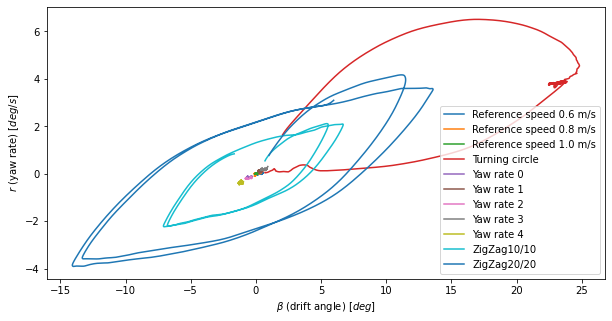

In [4]:
fig,ax=plt.subplots()
fig.set_size_inches(10,5)

data_ = data.copy()
data_['beta'] = -np.arctan2(data_['v'],data['u'])
data_['beta_deg'] = np.rad2deg(data_['beta'])
data_['r_deg'] = np.rad2deg(data_['r'])
data_['delta_deg'] = np.rad2deg(data_['delta'])

mask = runs_meta_data.index.isin(data_['id'].unique())
runs_meta_data_selected = runs_meta_data.loc[mask].copy()
mask = runs_meta_data_selected.duplicated(subset='description', keep='last')
runs_meta_data_selected = runs_meta_data_selected.loc[~mask]
data_groups = data_.groupby(by='id')

for id, meta_data in runs_meta_data_selected.iterrows():
    
    if not id in data_groups.groups.keys():
        continue
    
    df_ = data_groups.get_group(id)
    description = runs_meta_data.loc[id]['description']
    df_.plot(x='beta_deg', y='r_deg', ax=ax, label=description)
    
ax.set_ylabel(r'$r$ (yaw rate) $[deg/s]$')
ax.set_xlabel(r'$\beta$ (drift angle) $[deg]$');

fig_name = f"fig_beta_vs_r"
glue(fig_name, fig, display=False)

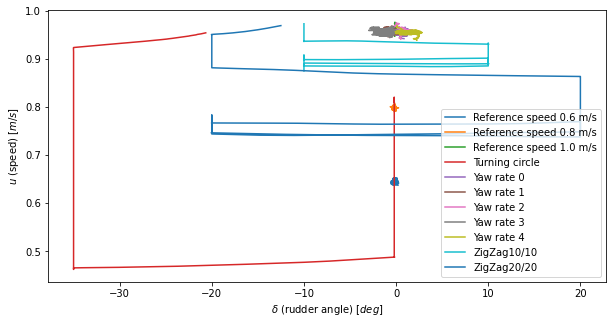

In [5]:
fig,ax=plt.subplots()
fig.set_size_inches(10,5)

for id, meta_data in runs_meta_data_selected.iterrows():
    
    if not id in data_groups.groups.keys():
        continue
    
    df_ = data_groups.get_group(id)
    description = runs_meta_data.loc[id]['description']
    df_.plot(x='delta_deg', y='u', ax=ax, label=description)
    
ax.set_ylabel(r'$u$ (speed) $[m/s]$')
ax.set_xlabel(r'$\delta$ (rudder angle) $[deg]$');

fig_name = f"fig_delta_vs_u"
glue(fig_name, fig, display=False)

Selecting which part of the data that should be in the test set can be done in many ways, depending on how the model should generalize to data outside the training data. The drift angles, yaw rates, rudder angles and speed are shown in {numref}```fig_beta_vs_r``` and {numref}```fig_delta_vs_u```. It can be seen that the Turning circle test is very different from the other tests in terms of: maximum drift and rudder angles as well as the minimum speed. 

```{glue:figure} fig_beta_vs_r
:figwidth: 600px
:name: "fig_beta_vs_r"
Drift angle and yaw rate from all the model tests.
```

```{glue:figure} fig_delta_vs_u
:figwidth: 600px
:name: "fig_delta_vs_u"
Drift angle and yaw rate from all the model tests.
```

The bias-variance tradeoff will be investigated for three scenarios having the three differen test sets:
* Random test set.
* Extreme values as test set

In [6]:
regression = regressions['vmm_martins_simple']

## Random test set

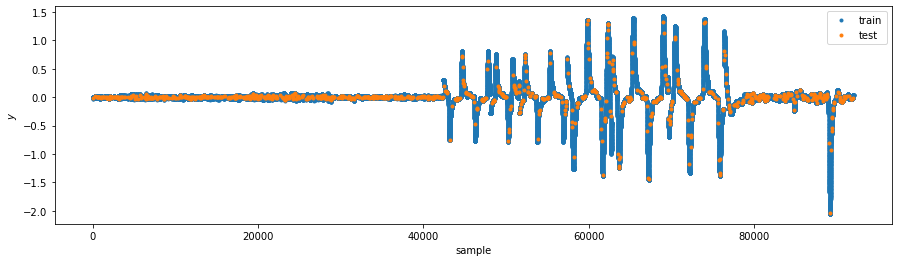

In [7]:
X_train, y_train, X_test, y_test, train_data = train_test_split(X=regression.X_N,
                                                                y=regression.y_N, 
                                                                test_ratio=0.01)


fig,ax=plt.subplots()
y_train.plot(ax=ax, label='train', style='.')
y_test.plot(ax=ax, label='test', style='.')
ax.set_xlabel('sample')
ax.set_ylabel('$y$')
ax.legend();

fig_name = "fig_test_split_random"
glue(fig_name, fig, display=False)

{numref}```fig_test_split_random``` show how the data (yaw acceleration in this case) from all the model tests have been randomly split into a training set and a test set.


```{glue:figure} fig_test_split_random
:figwidth: 600px
:name: "fig_test_split_random"
Random train test split for the yaw acceleration data.
```

In [8]:
def train_predict_vmms_random(dof='N'):

    df_sample_predictions = pd.DataFrame()
    
    for vmm_name, regression in regressions.items():
        
        X_name = f"X_{dof}"
        y_name = f"y_{dof}"
        X = getattr(regression, X_name)
        y = getattr(regression, y_name)
        
        X_train, y_train, X_test, y_test, train_data = train_test_split(X=X,
                                                                        y=y, 
                                                                        test_ratio=0.01)
        
        df_ = train_predict(train_data, X_test=X_test, y_test=y_test, train_ratio=0.005, N_trainings=50)
        df_['vmm'] = vmm_name
        df_sample_predictions = df_sample_predictions.append(df_, ignore_index=True)
        
    df_sample_predictions.sort_values(by=['parameters','x'], inplace=True)
    
    df_sample_predictions['residual'] = df_sample_predictions['y_hat'] - df_sample_predictions['z']
    df_sample_predictions['residual^2'] = df_sample_predictions['residual']**2
    return df_sample_predictions,y_test

,MSE,bias^2,variance
vmm,,,
vmm_linear,0.004004,0.062005,0.000056
vmm_martins_simple,0.001509,0.001499,0.000010
vmm_martin,0.001516,0.001495,0.000021
vmm_abkowitz_simple,0.001655,0.001631,0.000025
vmm_abkowitz,0.001575,0.001491,0.000086
vmm_abkowitz_expanded,0.001575,0.001491,0.000086


,MSE,bias^2,variance
vmm,,,
vmm_linear,0.000405,0.000400,0.000006
vmm_martins_simple,0.000393,0.000382,0.000012
vmm_martin,0.000323,0.000305,0.000018
vmm_abkowitz_simple,0.000288,0.000265,0.000024
vmm_abkowitz,0.000274,0.000228,0.000047
vmm_abkowitz_expanded,0.000280,0.000225,0.000057


,MSE,bias^2,variance
vmm,,,
vmm_linear,0.007275,0.007116,0.000162
vmm_martins_simple,0.007141,0.006868,0.000278
vmm_martin,0.004346,0.004000,0.000353
vmm_abkowitz_simple,0.003972,0.003407,0.000576
vmm_abkowitz,0.004646,0.003203,0.001472
vmm_abkowitz_expanded,0.004461,0.003075,0.001413


Wall time: 4.6 s


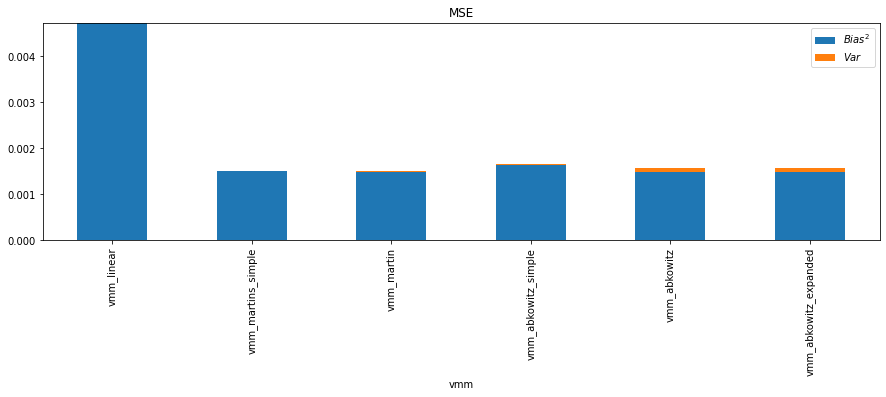

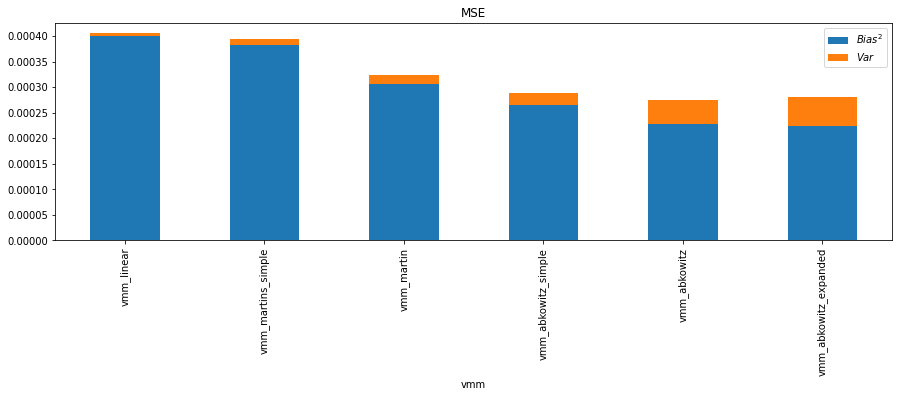

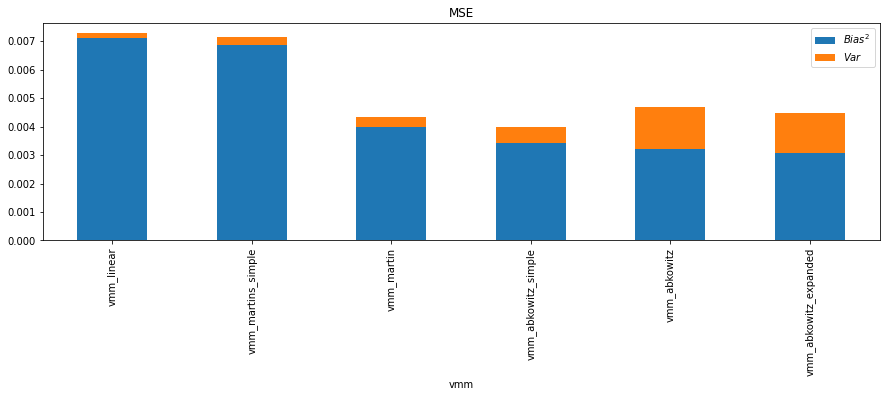

In [9]:
%%time

for dof in ['X','Y','N']:
    
    df_sample_predictions_random, y_test = train_predict_vmms_random(dof=dof)
    df_errors_random = errors(df_sample_predictions=df_sample_predictions_random, y_test=y_test)
    
    if dof=='X':
        smart_scale = True
    else:
        smart_scale = False
    
    fig = error_bars(df_errors_random, smart_scale=smart_scale)
    fig_name = f"fig_error_bars_random_{dof}"
    glue(fig_name, fig, display=False)   
    display(df_errors_random)

The generalization error expressed as the Mean Square Error MSE from prediction on the random test set with many models trained on subsets of the training set for the surge, sway and yaw regressions are shown in {numref}```fig_error_bars_random_X```, {numref}```fig_error_bars_random_X``` and {numref}```fig_error_bars_random_N```.

The errors have been decomposed into bias and variance. The VMM:s are ordered by their complexity (number of parameters) with the linear model being the simplest and the Abkowitz model being the most complex. It can be seen that the Abkowitz model has a large variance that contributes to the error.

```{glue:figure} fig_error_bars_random_X
:figwidth: 600px
:name: "fig_error_bars_random_X"
Error bars for surge acceleration regressions with random test set.
```

```{glue:figure} fig_error_bars_random_Y
:figwidth: 600px
:name: "fig_error_bars_random_Y"
Error bars for sway acceleration regressions with random test set.
```

```{glue:figure} fig_error_bars_random_N
:figwidth: 600px
:name: "fig_error_bars_random_N"
Error bars for yaw acceleration regressions with random test set.
```

## Extreme test set

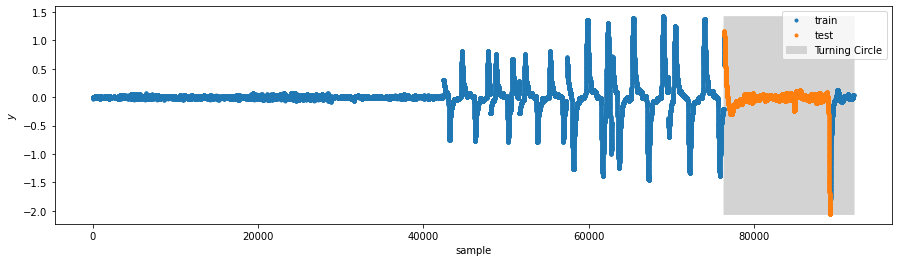

In [10]:
X_train, y_train, X_test, y_test, train_data = train_test_split_exteme(X=regression.X_N, y=regression.y_N, data=data, 
                                                                          min_ratio=0.05, 
                                                                          max_ratio=0.05,
                                                                          min_keys=['u'],
                                                                          max_keys=['v','r','delta'])


fig,ax=plt.subplots()

y_train.plot(ax=ax, label='train', style='.')
y_test.plot(ax=ax, label='test', style='.')

index = data.groupby(by='id').get_group(22774).index
ax.fill_between(index, y1=regression.y_N.max(), y2=regression.y_N.min(), color='lightgrey', label='Turning Circle')

ax.set_xlabel('sample')
ax.set_ylabel('$y$')
ax.legend();

fig_name = "fig_test_split_extreme"
glue(fig_name, fig, display=False)

{numref}```fig_test_split_extreme``` show how the data (yaw acceleration in this case) from all the model tests have been split into a training set and a test set. The test set have been selected to contain all the extreme values from the model tests being the data with 5% largest absolute value of $v$, $r$ and $\delta$ and the 5% smallest absolute value of $u$. This reflects most of the data from the Turning circle test as indicated in {numref}```fig_test_split_extreme```.



```{glue:figure} fig_test_split_extreme
:figwidth: 600px
:name: "fig_test_split_extreme"
Random train test split for the yaw acceleration data.
```

In [11]:
def train_predict_vmms_extreme(dof='N'):
    
    df_sample_predictions = pd.DataFrame()
    
    for vmm_name, regression in regressions.items():
        
        X_name = f"X_{dof}"
        y_name = f"y_{dof}"
        X = getattr(regression, X_name)
        y = getattr(regression, y_name)
                
        X_train, y_train, X_test, y_test, train_data = train_test_split_exteme(X=X,
                                                                            y=y,
                                                                            data=data,
                                                                            min_ratio=0.05, 
                                                                            max_ratio=0.05,
                                                                            min_keys=['u'],
                                                                            max_keys=['v','r'])
        
        df_ = train_predict(train_data, X_test=X_test, y_test=y_test, train_ratio=0.01, N_trainings=100)
        df_['vmm'] = vmm_name
        df_sample_predictions = df_sample_predictions.append(df_)
        
    df_sample_predictions.sort_values(by=['parameters','x'], inplace=True)
    
    df_sample_predictions['residual'] = df_sample_predictions['y_hat'] - df_sample_predictions['z']
    df_sample_predictions['residual^2'] = df_sample_predictions['residual']**2
    return df_sample_predictions, y_test

,MSE,bias^2,variance
vmm,,,
vmm_linear,0.007050,0.302922,0.000446
vmm_martins_simple,0.001331,0.001294,0.000038
vmm_martin,0.001601,0.001566,0.000036
vmm_abkowitz_simple,0.001696,0.001491,0.000206
vmm_abkowitz,0.002839,0.001617,0.001235
vmm_abkowitz_expanded,0.003081,0.001624,0.001472


,MSE,bias^2,variance
vmm,,,
vmm_linear,0.000993,0.000953,0.000039
vmm_martins_simple,0.001139,0.001048,0.000092
vmm_martin,0.001482,0.001407,0.000076
vmm_abkowitz_simple,0.001212,0.000926,0.000289
vmm_abkowitz,0.003852,0.002588,0.001277
vmm_abkowitz_expanded,0.003706,0.001878,0.001847


,MSE,bias^2,variance
vmm,,,
vmm_linear,0.022211,0.021697,0.000520
vmm_martins_simple,0.022399,0.020861,0.001553
vmm_martin,0.021798,0.020765,0.001044
vmm_abkowitz_simple,0.011893,0.009778,0.002136
vmm_abkowitz,0.037901,0.012956,0.025198
vmm_abkowitz_expanded,0.040413,0.018322,0.022313


Wall time: 35.3 s


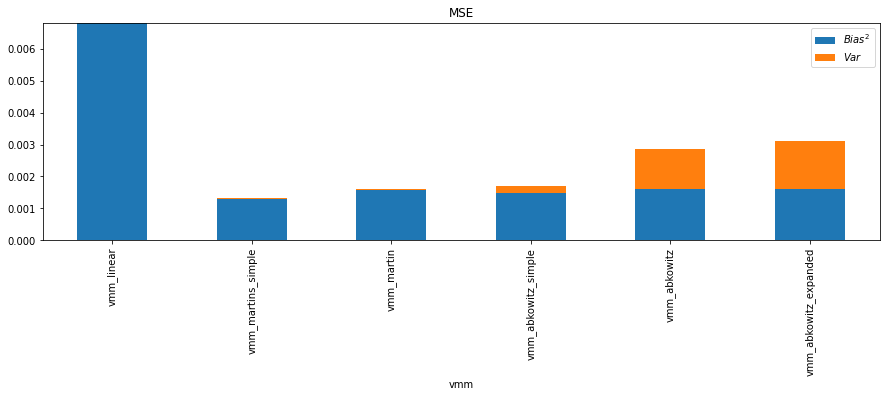

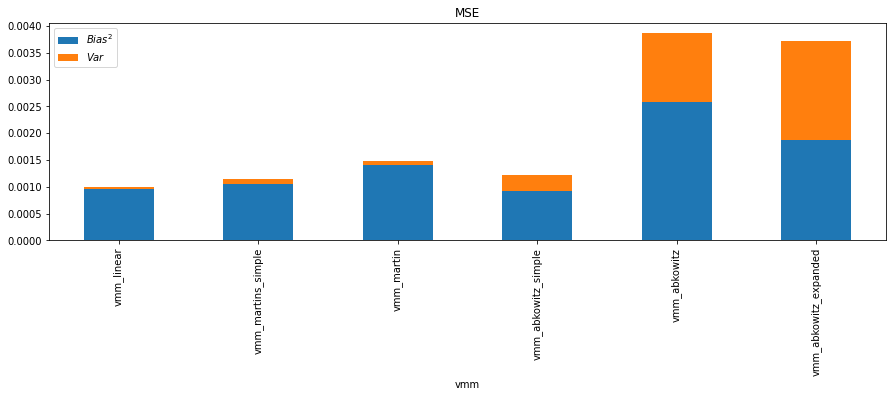

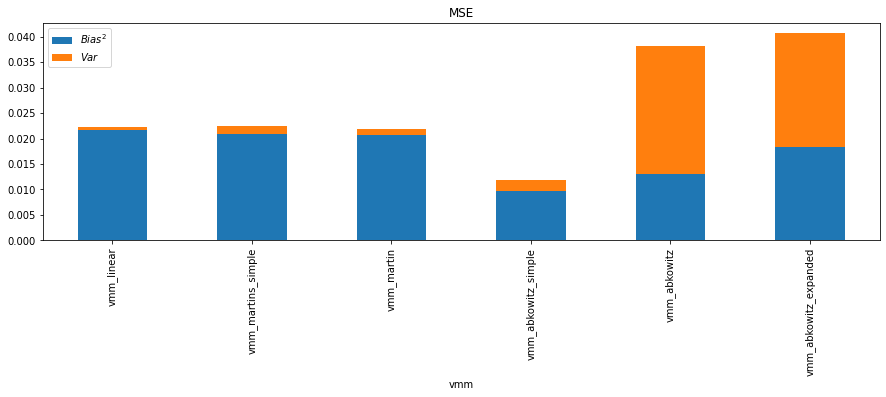

In [12]:
%%time

for dof in ['X','Y','N']:
    
    df_sample_predictions_extreme, y_test = train_predict_vmms_extreme(dof=dof)
    df_errors_extreme = errors(df_sample_predictions=df_sample_predictions_extreme, y_test=y_test)
    
    if dof=='X':
        smart_scale = True
    else:
        smart_scale = False
    
    fig = error_bars(df_errors_extreme, smart_scale=smart_scale)
    fig_name = f"fig_error_bars_extreme_{dof}"
    glue(fig_name, fig, display=False)   
    
    display(df_errors_extreme)

The generalization error expressed as the Mean Square Error MSE from prediction on the extreme test set with many models trained on subsets of the training set for the surge, sway and yaw regressions are shown in {numref}```fig_error_bars_extreme_X```, {numref}```fig_error_bars_extreme_X```, {numref}```fig_error_bars_extreme_N```.

The trend with high variance for the Abkowitz model, being the most complex model, is even more pronounced when using the extreme test set.

```{glue:figure} fig_error_bars_extreme_X
:figwidth: 600px
:name: "fig_error_bars_extreme_X"
Error bars for surge acceleration regressions with extreme test set.
```

```{glue:figure} fig_error_bars_extreme_Y
:figwidth: 600px
:name: "fig_error_bars_extreme_Y"
Error bars for sway acceleration regressions with extreme test set.
```

```{glue:figure} fig_error_bars_extreme_N
:figwidth: 600px
:name: "fig_error_bars_extreme_N"
Error bars for yaw acceleration regressions with extreme test set.
```